In [1]:
# matplotlib plots within notebook
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np

from datetime import datetime
from tqdm import tqdm

import os, sys

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


from l5kit.configs import load_config_data
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points





# Custom libs
sys.path.insert(0, './LyftAgent_lib')
from LyftAgent_lib import train_support as lyl_ts
from LyftAgent_lib import topologies as lyl_nn


import platform
print("python: "+platform.python_version())


import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
print('Using TensorFlow version: '+tf.__version__)
print('Using Keras version: '+keras.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

python: 3.6.9
Using TensorFlow version: 2.1.0
Using Keras version: 2.2.4-tf
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4709332387185489589
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8252239032957330848
physical_device_desc: "device: XLA_CPU device"
]


# Training and Model Config

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/tf/2020-10-Lyft/prediction-dataset"
# get config
cfg = load_config_data("./AgentPrediction_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'base_image_model': 'InceptionV3', 'history_encoder_recurrent_unit': 'GRU', 'history_encoder_recurrent_units_number': 64, 'num_hist_encode_layers': 2, 'hist_encode_units': [8, 16], 'hist_encode_activation': 'relu', 'path_generation_decoder_recurrent_unit': 'GRU', 'path_generation_decoder_recurrent_units_number': 128, 'pathDec_attention_pr_units': 256, 'num_path_decode_fc_layers': 1, 'path_decode_fc_units': [16], 'path_decode_fc_activation': 'relu', 'history_num_frames': 10, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'training_params': {'gen_lr_list': [0.001, 0.0001, 5e-05, 1e-05], 'gen_lr_lims': [10, 30, 60, 100], 'number_of_scenes': 16000, 'randomize_scenes': True, 'frames_per_scene': 1, 'randomize_frames': True, 'epochs_train': 100, 'use_teacher_force': True, 'teacher_force_decay': 0.025, 'teacher_force_list': [1.0, 0.75, 0.5, 0.25, 0.0], 'teacher_force_lims': [5,

In [3]:
# Get parameters
model_map_input_shape      = (cfg["raster_params"]["raster_size"][0],
                              cfg["raster_params"]["raster_size"][1])

base_image_arch            = cfg["model_params"]["base_image_model"]

num_future_frames          = cfg["model_params"]["future_num_frames"]

num_hist_frames            = cfg["model_params"]["history_num_frames"]


histEnc_recurrent_unit     = cfg["model_params"]["history_encoder_recurrent_unit"]
histEnc_recurrent_unit_num = cfg["model_params"]["history_encoder_recurrent_units_number"]
pathDec_recurrent_unit     = cfg["model_params"]["path_generation_decoder_recurrent_unit"]
pathDec_recurrent_unit_num = cfg["model_params"]["path_generation_decoder_recurrent_units_number"]



gen_batch_size             = cfg["train_data_loader"]["batch_size"]
gen_lr_list                = cfg["training_params"]["gen_lr_list"]
gen_lr_lims                = cfg["training_params"]["gen_lr_lims"]


number_of_scenes           = cfg["training_params"]["number_of_scenes"]
frames_per_scene           = cfg["training_params"]["frames_per_scene"]
randomize_frames           = cfg["training_params"]["randomize_frames"]
randomize_scenes           = cfg["training_params"]["randomize_scenes"]
epochs_train               = cfg["training_params"]["epochs_train"]
# teacher_force_decay        = cfg["training_params"]["teacher_force_decay"]
teacher_force_list         = cfg["training_params"]["teacher_force_list"]
teacher_force_lims         = cfg["training_params"]["teacher_force_lims"]


use_teacher_force          = cfg["training_params"]["use_teacher_force"]
init_decoder_on_history    = cfg["training_params"]["init_decoder_on_history"]
retrain_inputs_image_model = cfg["training_params"]["retrain_inputs_image_model"]

map_input_channels = 3+2


# Epoch to restart training (0 means start over)
restart_epoch = 10

# Dataset Loader

### Train Set

In [4]:
dm = LocalDataManager()
dataset_path = dm.require(cfg["train_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)
rast = build_rasterizer(cfg, dm)
train_dataset = AgentDataset(cfg, zarr_dataset, rast)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [5]:
tf_train_dataset = lyl_ts.get_tf_dataset(train_dataset, 
                                   num_hist_frames,
                                   model_map_input_shape,
                                   num_future_frames,
                                   randomize_frame=randomize_frames,
                                   randomize_scene=randomize_scenes, 
                                   num_scenes=number_of_scenes, 
                                   frames_per_scene = frames_per_scene)

# Map sample pre-processing function
tf_train_dataset = tf_train_dataset.map(lambda x: lyl_ts.tf_get_input_sample(x))
# Shuffle dataset
tf_train_dataset = tf_train_dataset.shuffle(buffer_size=64, reshuffle_each_iteration=True)#.repeat(-1)
# Set batch size
tf_train_dataset = tf_train_dataset.batch(batch_size=gen_batch_size)

    

### Validation Set

In [6]:
dataset_path_val = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset_val = ChunkedDataset(dataset_path_val)
zarr_dataset_val.open()
print(zarr_dataset_val)
validation_dataset = AgentDataset(cfg, zarr_dataset_val, rast)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  4030296   | 312617887  |    29277930   |      111.97     |        248.48        |        77.57         |        24.85         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [7]:
tf_validation_dataset = lyl_ts.get_tf_dataset(validation_dataset, 
                                           num_hist_frames,
                                           model_map_input_shape,
                                           num_future_frames,
                                           randomize_frame=True,
                                           randomize_scene=True, 
                                           num_scenes=number_of_scenes, 
                                           frames_per_scene = frames_per_scene)

# Map sample pre-processing function
tf_validation_dataset = tf_validation_dataset.map(lambda x: lyl_ts.tf_get_input_sample(x))
# Shuffle dataset
tf_validation_dataset = tf_validation_dataset.shuffle(buffer_size = 64, reshuffle_each_iteration=False)#.repeat(-1)
# Set batch size
tf_validation_dataset = tf_validation_dataset.batch(batch_size=gen_batch_size)

# Build Models

In [8]:
# Pick up from previous step
if restart_epoch>0:
    
    ImageEncModel = lyl_ts.load_model('./output/ImageEncModel', 'epoch_%d'%restart_epoch, use_keras=True)
    
    HistEncModel = lyl_ts.load_model('./output/HistEncModel', 'epoch_%d'%restart_epoch, use_keras=True)

    custom_layers_dict = {'BahdanauAttention': lyl_nn.BahdanauAttention}
    PathDecModel = lyl_ts.load_model('./output/PathDecModel', 'epoch_%d'%restart_epoch, use_keras=True, custom_obj_dict=custom_layers_dict)
    
    print('All models succesfully loaded.')
else:
    
    # ---------------------- IMAGE ENCODER --------------------------
    # Load pretrained image processing model
    try:
        base_model_builder = getattr(keras.applications, base_image_arch)
    except:
        raise Exception('Base image processing model not found. Reuquested model: %s'%base_image_arch)


    base_img_model = base_model_builder(include_top=False, weights='imagenet')

    ImageEncModel = lyl_nn.imageEncodingModel(base_img_model, cfg)

    # ---------------------- PATH HISTORY ENCODER ------------------
    HistEncModel = lyl_nn.pathEncodingModel(cfg)
    
    # ---------------------- PATH DECODER --------------------------
    PathDecModel = lyl_nn.pathDecoderModel(cfg, ImageEncModel, HistEncModel)


All models succesfully loaded.


### Show model information

In [9]:
ImageEncModel.summary()
tf.keras.utils.plot_model(ImageEncModel, show_shapes=True, show_layer_names=True)

Model: "Image_Encodding_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_map (InputLayer)          [(None, 224, 224, 5) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 1440        Input_map[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________

Model: "History_Encoding_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_history_frames (InputL [(16, 1, 3)]              0         
_________________________________________________________________
dense (Dense)                (16, 1, 8)                32        
_________________________________________________________________
dense_1 (Dense)              (16, 1, 16)               144       
_________________________________________________________________
gru (GRU)                    [(16, 64), (16, 64)]      15744     
Total params: 15,920
Trainable params: 15,920
Non-trainable params: 0
_________________________________________________________________


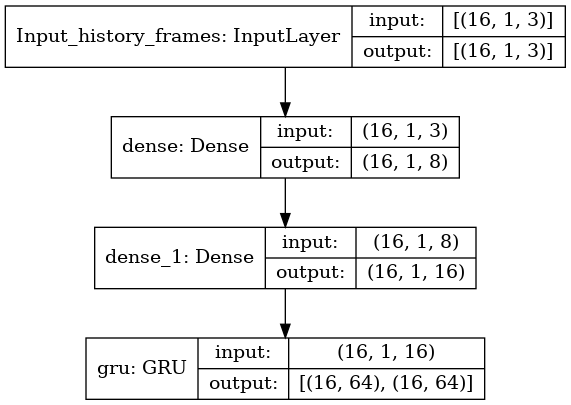

In [10]:
HistEncModel.summary()
tf.keras.utils.plot_model(HistEncModel, show_shapes=True, show_layer_names=True)

Model: "Path_Decoder_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Last_Hidden_State (InputL [(16, 128)]          0                                            
__________________________________________________________________________________________________
Input_Image_Features (InputLaye [(16, 25, 2048)]     0                                            
__________________________________________________________________________________________________
bahdanau_attention (BahdanauAtt ((16, 2048), (16, 25 557825      Input_Last_Hidden_State[0][0]    
                                                                 Input_Image_Features[0][0]       
__________________________________________________________________________________________________
dense_5 (Dense)                 (16, 64)             131136      bahdanau_attenti

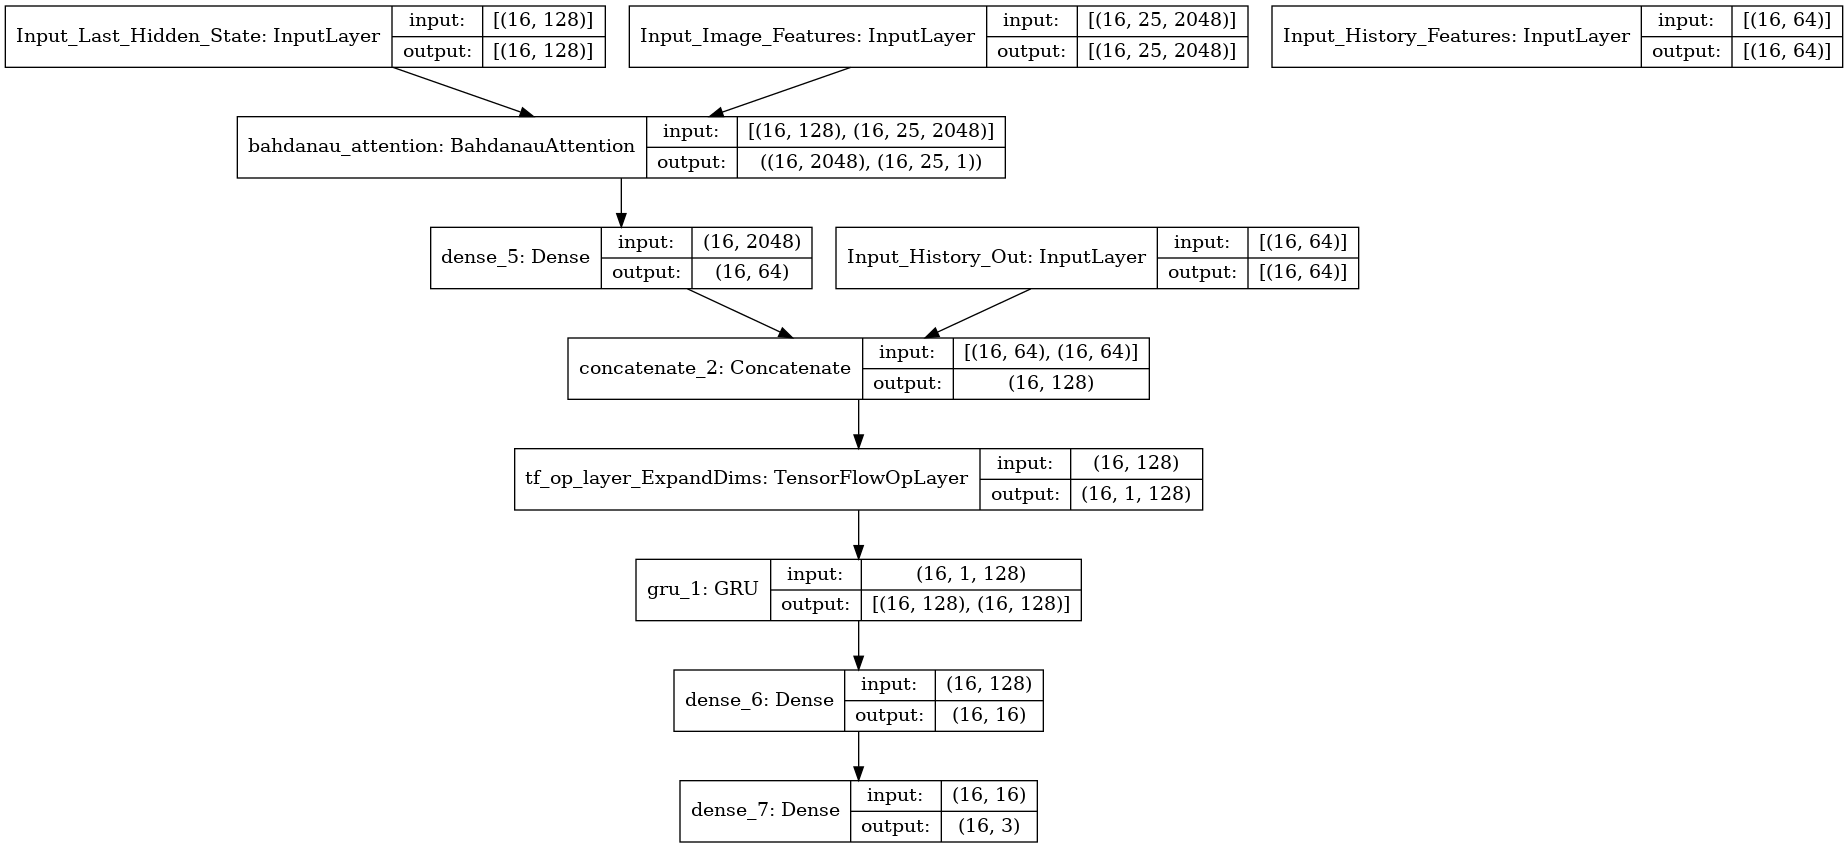

In [11]:
PathDecModel.summary()
tf.keras.utils.plot_model(PathDecModel, show_shapes=True, show_layer_names=True)


# Train!

In [12]:
optimizer_gen = keras.optimizers.Adam(lr=1.0, beta_1=0.9, beta_2=0.99, epsilon=1.0e-8)

train_genL2_loss = keras.metrics.Mean(name='train_gen_L2_loss')

In [ ]:
teacher_force_base = 1.0
teacher_force = teacher_force_base   

for epoch in range(restart_epoch, epochs_train):
   
    if use_teacher_force:
        # Modulate teacher force
        teacher_force = lyl_ts.get_teacher_force_weight(teacher_force_list, 
                                                 teacher_force_lims, 
                                                 epoch, 
                                                 teacher_force, 
                                                 linearize=True)
    #         teacher_force = teacher_force_base*np.exp(-epoch*teacher_force_decay)

    # Update learning rate
    lyl_ts.update_lr(gen_lr_list, gen_lr_lims, epoch, optimizer_gen)
    
    # Flush stdout to avoid tqdm overlap
    sys.stdout.flush()
                              
    train_genL2_loss_aux = 0
    idx_gen_train = 0
    
    train_dataset_prog_bar = tqdm(tf_train_dataset, total=(number_of_scenes/gen_batch_size))
    for (thisSampleMapComp, thisSampeHistPath, thisSampeTargetPath, 
         thisHistAvail, thisTargetAvail, 
         thisTimeStamp, thisTrackID, thisRasterFromAgent) in train_dataset_prog_bar:


        PathDecModel.reset_states()
        HistEncModel.reset_states()
        lyl_ts.generator_train_step(thisSampleMapComp, 
                                    thisSampeHistPath, 
                                    thisSampeTargetPath, 
                                    thisHistAvail, 
                                    thisTargetAvail,
                                    ImageEncModel,
                                    HistEncModel, 
                                    PathDecModel, 
                                    optimizer_gen, 
                                    train_genL2_loss,
                                    tf.constant(tf.zeros(PathDecModel.inputs[-1].shape)),
                                    use_teacher_force=use_teacher_force,
                                    teacher_force_weight = tf.constant(teacher_force, dtype=tf.float32))

        thisL2 = train_genL2_loss.result()
        if np.isnan(thisL2):
            raise Exception('Bad potato... step %d'%idx_gen_train)
            
        train_genL2_loss_aux += thisL2
        train_genL2_loss.reset_states()


        print_gen_L2 = train_genL2_loss_aux/(idx_gen_train+1)
                              
        
        # Update progress bar
        msg_string = '(Epoch %d/%d) Gen. Loss: %.2f (last %.2f) '%(epoch+1,
                                                                         epochs_train,
                                                                         print_gen_L2, 
                                                                         thisL2)
        if use_teacher_force:
            msg_string += '(t.f. = %.2f)'%teacher_force
        train_dataset_prog_bar.set_description(msg_string)
        

        idx_gen_train += 1
        
    # Save
    lyl_ts.save_model(ImageEncModel, './output/ImageEncModel', 'epoch_%d'%epoch, use_keras=True)
    lyl_ts.save_model(HistEncModel, './output/HistEncModel', 'epoch_%d'%epoch, use_keras=True)
    lyl_ts.save_model(PathDecModel, './output/PathDecModel', 'epoch_%d'%epoch, use_keras=True)

    # Validate
    if (epoch%10 == 0) and (epoch > 0):
        # Once every ten, a full validation step
        lyl_ts.validate_model(tf_validation_dataset, 
                              ImageEncModel, HistEncModel, PathDecModel)
    else:
        lyl_ts.validate_model(tf_validation_dataset, 
                              ImageEncModel, HistEncModel, PathDecModel, 
                              steps_validate = 100)

   
    
        
            

Teacher force weight set to: 0.725
Learning rate set to: 0.0001


(Epoch 12/100) Gen. Loss: 0.09 (last 0.34) (t.f. = 0.72): 100%|██████████| 1000/1000.0 [37:18<00:00,  2.24s/it]
Validation: L2 Loss: 21.71 (last 16.19) : 100%|██████████| 100/100 [02:14<00:00,  1.35s/it]

Teacher force weight set to: 0.7



(Epoch 13/100) Gen. Loss: 0.08 (last 0.05) (t.f. = 0.70):  51%|█████     | 507/1000.0 [18:48<19:55,  2.43s/it]

In [ ]:
# (Epoch 1/100) Gen. Loss: 163.90 (last 6.09) (t.f. = 1.00): 100%|██████████| 1000/1000.0 [38:14<00:00,  2.29s/it]  
# Validation: L2 Loss: 530.11 (last 612.38) : 100%|██████████| 100/100 [02:56<00:00,  1.77s/it]
# (Epoch 2/100) Gen. Loss: 9.46 (last 9.42) (t.f. = 0.98): 100%|██████████| 1000/1000.0 [34:39<00:00,  2.08s/it] 
# Validation: L2 Loss: 249.13 (last 42.58) : 100%|██████████| 100/100 [02:12<00:00,  1.32s/it]
# (Epoch 3/100) Gen. Loss: 5.04 (last 11.13) (t.f. = 0.95): 100%|██████████| 1000/1000.0 [36:33<00:00,  2.19s/it]
# Validation: L2 Loss: 315.09 (last 258.92) : 100%|██████████| 100/100 [03:00<00:00,  1.81s/it]
# (Epoch 4/100) Gen. Loss: 3.07 (last 0.42) (t.f. = 0.93): 100%|██████████| 1000/1000.0 [37:47<00:00,  2.27s/it]
# Validation: L2 Loss: 80.53 (last 112.37) : 100%|██████████| 100/100 [03:04<00:00,  1.84s/it]
# (Epoch 5/100) Gen. Loss: 0.44 (last 0.10) (t.f. = 0.90): 100%|██████████| 1000/1000.0 [34:49<00:00,  2.09s/it]
# Validation: L2 Loss: 44.43 (last 87.52) : 100%|██████████| 100/100 [03:13<00:00,  1.93s/it] 
# (Epoch 6/100) Gen. Loss: 0.33 (last 0.06) (t.f. = 0.88): 100%|██████████| 1000/1000.0 [34:48<00:00,  2.09s/it]
# Validation: L2 Loss: 74.61 (last 66.65) : 100%|██████████| 100/100 [02:54<00:00,  1.75s/it]
# (Epoch 7/100) Gen. Loss: 0.27 (last 0.09) (t.f. = 0.86): 100%|██████████| 1000/1000.0 [34:36<00:00,  2.08s/it]
# Validation: L2 Loss: 50.86 (last 19.35) : 100%|██████████| 100/100 [03:26<00:00,  2.07s/it]
# (Epoch 8/100) Gen. Loss: 0.24 (last 0.60) (t.f. = 0.84): 100%|██████████| 1000/1000.0 [36:54<00:00,  2.21s/it]
# Validation: L2 Loss: 134.68 (last 87.44) : 100%|██████████| 100/100 [03:19<00:00,  2.00s/it]
# (Epoch 9/100) Gen. Loss: 0.21 (last 0.18) (t.f. = 0.82): 100%|██████████| 1000/1000.0 [39:37<00:00,  2.38s/it]
# Validation: L2 Loss: 678.76 (last 1163.66) : 100%|██████████| 100/100 [03:03<00:00,  1.84s/it]
# (Epoch 10/100) Gen. Loss: 0.18 (last 0.04) (t.f. = 0.80): 100%|██████████| 1000/1000.0 [42:11<00:00,  2.53s/it]
# Validation: L2 Loss: 67.41 (last 5.40) : 100%|██████████| 100/100 [03:11<00:00,  1.92s/it]  



# (Epoch 11/100) Gen. Loss: 0.18 (last 0.12) (t.f. = 0.75): 100%|██████████| 1000/1000.0 [37:15<00:00,  2.24s/it]
# Validation: L2 Loss: 449.16 (last 348.36) : 100%|██████████| 100/100 [02:23<00:00,  1.44s/it]
# (Epoch 12/100) Gen. Loss: 0.09 (last 0.34) (t.f. = 0.72): 100%|██████████| 1000/1000.0 [37:18<00:00,  2.24s/it]
# Validation: L2 Loss: 21.71 (last 16.19) : 100%|██████████| 100/100 [02:14<00:00,  1.35s/it]






# (Epoch 11/100) Gen. Loss: 0.19 (last 0.13) (t.f. = 0.78): 100%|██████████| 1000/1000.0 [39:38<00:00,  2.38s/it]
# Validation: L2 Loss: 109.08 (last 140.41) : 100%|██████████| 100/100 [02:49<00:00,  1.69s/it]
# (Epoch 12/100) Gen. Loss: 0.16 (last 0.15) (t.f. = 0.76): 100%|██████████| 1000/1000.0 [38:45<00:00,  2.33s/it]
# Validation: L2 Loss: 742.68 (last 311.69) : 100%|██████████| 100/100 [02:14<00:00,  1.35s/it] 
# (Epoch 13/100) Gen. Loss: 0.21 (last 0.39) (t.f. = 0.74): 100%|██████████| 1000/1000.0 [35:50<00:00,  2.15s/it]
# Validation: L2 Loss: 26.29 (last 1.75) : 100%|██████████| 100/100 [02:29<00:00,  1.50s/it] 
# (Epoch 14/100) Gen. Loss: 0.20 (last 0.22) (t.f. = 0.72): 100%|██████████| 1000/1000.0 [38:36<00:00,  2.32s/it]
# Validation: L2 Loss: 531.78 (last 480.35) : 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]
# (Epoch 15/100) Gen. Loss: 0.19 (last 0.16) (t.f. = 0.70): 100%|██████████| 1000/1000.0 [41:02<00:00,  2.46s/it]
# Validation: L2 Loss: 134.84 (last 142.81) : 100%|██████████| 100/100 [02:35<00:00,  1.56s/it]
# (Epoch 16/100) Gen. Loss: 0.19 (last 0.07) (t.f. = 0.69): 100%|██████████| 1000/1000.0 [40:53<00:00,  2.45s/it]
# Validation: L2 Loss: 77.13 (last 64.98) : 100%|██████████| 100/100 [02:14<00:00,  1.34s/it] 
# (Epoch 17/100) Gen. Loss: 0.21 (last 0.16) (t.f. = 0.67): 100%|██████████| 1000/1000.0 [37:57<00:00,  2.28s/it]
# Validation: L2 Loss: 76.26 (last 43.21) : 100%|██████████| 100/100 [02:07<00:00,  1.28s/it] 
# (Epoch 18/100) Gen. Loss: 0.23 (last 0.35) (t.f. = 0.65): 100%|██████████| 1000/1000.0 [37:23<00:00,  2.24s/it]
# Validation: L2 Loss: 260.92 (last 296.97) : 100%|██████████| 100/100 [03:38<00:00,  2.18s/it]
# (Epoch 19/100) Gen. Loss: 0.48 (last 0.17) (t.f. = 0.64): 100%|██████████| 1000/1000.0 [37:27<00:00,  2.25s/it]
# Validation: L2 Loss: 129.72 (last 112.23) : 100%|██████████| 100/100 [02:21<00:00,  1.42s/it]
# (Epoch 20/100) Gen. Loss: 0.47 (last 0.62) (t.f. = 0.62): 100%|██████████| 1000/1000.0 [37:40<00:00,  2.26s/it]
# Validation: L2 Loss: 122.94 (last 52.23) : 100%|██████████| 100/100 [02:16<00:00,  1.36s/it]
# (Epoch 21/100) Gen. Loss: 0.40 (last 0.10) (t.f. = 0.61): 100%|██████████| 1000/1000.0 [37:32<00:00,  2.25s/it]
# Validation: L2 Loss: 240.13 (last 304.33) : 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]

# (Epoch 23/100) Gen. Loss: 0.86 (last 0.22) (t.f. = 0.58): 100%|██████████| 1000/1000.0 [38:52<00:00,  2.33s/it]
# Validation: L2 Loss: 58.10 (last 0.02) : 100%|██████████| 100/100 [02:17<00:00,  1.38s/it]  
# (Epoch 24/100) Gen. Loss: 1.18 (last 0.64) (t.f. = 0.56): 100%|██████████| 1000/1000.0 [39:26<00:00,  2.37s/it]
# Validation: L2 Loss: 65.05 (last 42.25) : 100%|██████████| 100/100 [02:21<00:00,  1.42s/it]
# (Epoch 25/100) Gen. Loss: 22.51 (last 57.64) (t.f. = 0.55): 100%|██████████| 1000/1000.0 [38:53<00:00,  2.33s/it]
# Validation: L2 Loss: 561.60 (last 766.11) : 100%|██████████| 100/100 [02:43<00:00,  1.64s/it]

# Full Validation

In [ ]:
lyl_tf.validate_model(tf_validation_dataset, 
                          ImageEncModel, HistEncModel, PathDecModel)

### Single sample tests

In [ ]:
for (valSampleMapComp, valSampeHistPath, valSampeTargetPath, 
         valHistAvail, valTargetAvail, 
     valTimeStamp, valTrackID, valRasterFromAgent) in tf_validation_dataset:
    break

In [ ]:
PathDecModel.reset_states()
HistEncModel.reset_states()
valPredPath = lyl_tf.model_forward_pass(valSampleMapComp,
                                        valSampeHistPath,
                                        50, 
                                        ImageEncModel, HistEncModel, PathDecModel,
                                        use_teacher_force=False, target_path=valSampeTargetPath)

valPredPath = valPredPath.numpy()
valLoss = lyl_tf.calc_loss(valPredPath, valSampeTargetPath, valTargetAvail)
valLoss = valLoss.numpy()
np.mean(valLoss)

In [ ]:
idx_sample = np.random.randint(gen_batch_size)
num_targets = np.sum(valTargetAvail.numpy(), axis=1)[idx_sample].astype(np.int32)


plt.figure(dpi=150)
plt.subplot(1,3,1)
img_aux = (np.copy(valSampleMapComp[idx_sample,:,:,:3].numpy())).astype(np.int32)
draw_trajectory(img_aux,
                transform_points(valSampeTargetPath[idx_sample,:num_targets,:2].numpy(), 
                                 valRasterFromAgent[idx_sample,:num_targets,:].numpy()),
                TARGET_POINTS_COLOR, 
                yaws=np.expand_dims(valSampeTargetPath[idx_sample,:num_targets,2].numpy(), axis=-1))

plt.imshow(img_aux, origin='botom')
plt.subplot(1,3,2)
plt.imshow(valSampleMapComp[idx_sample,:,:,3].numpy().astype(np.int32), origin='botom')
plt.subplot(1,3,3)
plt.imshow(valSampleMapComp[idx_sample,:,:,4].numpy().astype(np.int32), origin='botom')

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(dpi=150)
plt.subplot(1,3,1)
img_aux = (np.copy(valSampleMapComp[idx_sample,:,:,:3].numpy())).astype(np.int32)
draw_trajectory(img_aux,
                transform_points(valPredPath[idx_sample,:num_targets,:2], 
                                 valRasterFromAgent[idx_sample,:num_targets,:].numpy()),
                TARGET_POINTS_COLOR, 
                yaws=np.expand_dims(valPredPath[idx_sample,:num_targets,2], axis=-1))

plt.imshow(img_aux, origin='botom')
plt.subplot(1,3,2)
plt.imshow(valSampleMapComp[idx_sample,:,:,3].numpy().astype(np.int32), origin='botom')
plt.subplot(1,3,3)
plt.imshow(valSampleMapComp[idx_sample,:,:,4].numpy().astype(np.int32), origin='botom')

plt.tight_layout()
plt.show()

In [ ]:
num_targets = np.sum(valTargetAvail.numpy(), axis=0)[idx_sample].astype(np.int32)

print(idx_sample, num_targets)
print(valLoss[idx_sample])
print(valPredPath[idx_sample,:num_targets,0])
print(valSampeTargetPath.numpy()[idx_sample,:num_targets,0])

plt.subplot(1,3,1)
plt.plot(valPredPath[idx_sample,:num_targets,0])
plt.plot(valSampeTargetPath.numpy()[idx_sample,:num_targets,0])
print(valPredPath[idx_sample,:num_targets,1])
print(valSampeTargetPath.numpy()[idx_sample,:num_targets,1])
plt.subplot(1,3,2)
plt.plot(valPredPath[idx_sample,:num_targets,1])
plt.plot(valSampeTargetPath.numpy()[idx_sample,:num_targets,1])
plt.subplot(1,3,3)
plt.plot(valPredPath[idx_sample,:num_targets,2])
plt.plot(valSampeTargetPath.numpy()[idx_sample,:num_targets,2])

plt.figure()
plt.subplot(1,3,1)
plt.plot(valSampeTargetPath.numpy()[idx_sample,:num_targets,0], valPredPath[idx_sample,:num_targets,0], '*-')
plt.plot(valSampeTargetPath[idx_sample,:num_targets,0], valSampeTargetPath[idx_sample,:num_targets,0], '-.')
plt.subplot(1,3,2)
plt.plot(valSampeTargetPath.numpy()[idx_sample,:num_targets,1], valPredPath[idx_sample,:num_targets,1], '*-')
plt.plot(valSampeTargetPath[idx_sample,:num_targets,1], valSampeTargetPath[idx_sample,:num_targets,1], '-.')
plt.subplot(1,3,3)
plt.plot(valSampeTargetPath.numpy()[idx_sample,:num_targets,2], valPredPath[idx_sample,:num_targets,2], '*-')
plt.plot(valSampeTargetPath[idx_sample,:num_targets,2], valSampeTargetPath[idx_sample,:num_targets,2], '-.')

In [ ]:
from importlib import reload
reload(lyl_ts)